In [1]:
# 주요 라이브러리 import
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, classification_report, make_scorer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
ROOT_DIR = "data"
RANDOM_STATE = 110

In [3]:
# 데이터 로드
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))

In [4]:
# 데이터 전처리 함수
def preprocess_data(df, onehot_encoder=None, is_train=True):
    df = df.copy()
    df.dropna(axis=1, how='all', inplace=True)

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns

    # 수치형 열 처리
    numeric_imputer = SimpleImputer(strategy='median')
    df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

    # 범주형 열 처리
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

    # 극단값 처리
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower_bound, upper_bound)

    # 정수형 열 처리
    int_cols = df.select_dtypes(include=['int64']).columns
    for col in int_cols:
        df[col] = df[col].round().astype('int64')

    # 'Set ID' 열이 있다면 제거
    if 'Set ID' in df.columns:
        df = df.drop('Set ID', axis=1)
    
    df.dropna(axis=1, how='all', inplace=True)

    # 범주형 변수에 대한 원핫 인코딩
    if is_train:
        onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_cats = onehot_encoder.fit_transform(df[categorical_cols])
    else:
        encoded_cats = onehot_encoder.transform(df[categorical_cols])
    
    encoded_feature_names = onehot_encoder.get_feature_names_out(categorical_cols)
    
    # 원핫 인코딩된 데이터를 데이터프레임에 추가
    encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names, index=df.index)
    df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

    return df, onehot_encoder

In [5]:
# 'target' 열을 별도로 저장
target = train_data['target']

In [6]:
# 'target' 열을 제외한 나머지 데이터 전처리
train_data_without_target = train_data.drop('target', axis=1)

In [7]:
# 데이터 전처리 적용
train_data_processed, onehot_encoder = preprocess_data(train_data_without_target, is_train=True)

In [8]:
# 전처리된 데이터에 'target' 열 다시 추가
train_data_processed['target'] = target

In [9]:
# train_data_processed 확인
print("Train data demo shape:", train_data_processed.shape)
print("\nTrain data demo preview:")
print(train_data_processed.head())
print("\nTrain data demo info:")
train_data_processed.info()
train_data_processed

Train data demo shape: (40506, 2875)

Train data demo preview:
   Insp. Seq No._Dam  CURE END POSITION X Collect Result_Dam  \
0                1.0                                   240.0   
1                1.0                                   240.0   
2                1.0                                  1000.0   
3                1.0                                  1000.0   
4                1.0                                   240.0   

   CURE END POSITION Z Collect Result_Dam  \
0                                     2.5   
1                                     2.5   
2                                    12.5   
3                                    12.5   
4                                     2.5   

   CURE END POSITION Θ Collect Result_Dam  CURE SPEED Collect Result_Dam  \
0                                   -90.0                           70.0   
1                                   -90.0                           70.0   
2                                    90.0            

,Insp. Seq No._Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION Z Collect Result_Dam,CURE STANDBY POSITION Θ Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Z Collect Result_Dam,...,Workorder_Fill2_4F1XB596-1,Workorder_Fill2_4F1XB738-1,Workorder_Fill2_4F1XB758-1,Workorder_Fill2_4F1XB758-2,Insp Judge Code_Fill2_OK,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2_305,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2_835.5,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2_OK,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2_OK,target
0,1.0,240.0,2.5,-90.0,70.0,1150.0,33.5,0.0,1030.0,33.5,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Normal
1,1.0,240.0,2.5,-90.0,70.0,1150.0,33.5,0.0,1030.0,33.5,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Normal
2,1.0,1000.0,12.5,90.0,70.0,1150.0,33.5,0.0,280.0,33.5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,Normal
3,1.0,1000.0,12.5,90.0,70.0,1150.0,33.5,0.0,280.0,33.5,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Normal
4,1.0,240.0,2.5,-90.0,70.0,1150.0,33.5,0.0,1030.0,33.5,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,1.0,240.0,2.5,-90.0,70.0,1150.0,33.5,0.0,1030.0,33.5,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Normal
40502,1.0,1000.0,12.5,90.0,70.0,1150.0,33.5,0.0,280.0,33.5,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Normal
40503,1.0,240.0,2.5,-90.0,70.0,1150.0,33.5,0.0,1030.0,33.5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,Normal
40504,1.0,1000.0,12.5,90.0,70.0,1150.0,33.5,0.0,280.0,33.5,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Normal


In [10]:
# 레이블 인코딩
le = LabelEncoder()
y = le.fit_transform(train_data_processed['target'])

In [11]:
# 특성 선택 (target 열 제외)
features = train_data_processed.drop('target', axis=1).columns
X = train_data_processed[features]

train_features = X.columns.tolist()

In [12]:
# 전체 데이터셋에 대한 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# autoencoder 모델 정의
def create_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    
    autoencoder.compile(optimizer=Adam(), loss='mse')
    
    return autoencoder, encoder

In [14]:
# 각 차원에 대해 재구성 오류와 설명된 분산 계산
def analyze_dimensions(X, max_dim=100):
    input_dim = X.shape[1]
    reconstruction_errors = []
    explained_variances = []
    
    for encoding_dim in range(1, min(max_dim, input_dim) + 1):
        autoencoder, encoder = create_autoencoder(input_dim, encoding_dim)
        autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True, verbose=0)
        
        encoded_data = encoder.predict(X)
        decoded_data = autoencoder.predict(X)
        
        reconstruction_error = np.mean(np.square(X - decoded_data))
        reconstruction_errors.append(reconstruction_error)
        
        total_variance = np.sum(np.var(X, axis=0))
        explained_variance = np.sum(np.var(encoded_data, axis=0))
        explained_variances.append(explained_variance / total_variance)
    
    return reconstruction_errors, explained_variances


In [15]:
# 인코딩된 차원과 재구성 오류 간 관계를 나타내는 그래프(Elbow Plot)와 설명된 분산 비율 간 관계를 나타내는 그래프(Scree Plot) 생성
def plot_analysis(reconstruction_errors, explained_variances):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(reconstruction_errors) + 1), reconstruction_errors, 'bo-')
    plt.xlabel('Encoding Dimension')
    plt.ylabel('Reconstruction Error')
    plt.title('Elbow Plot')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(explained_variances) + 1), explained_variances, 'ro-')
    plt.xlabel('Encoding Dimension')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Scree Plot')
    
    plt.tight_layout()
    plt.show()

In [16]:
# 최소 분산 비율(설명된 분산의 누적치)을 구해 최적의 encoding dimension 계산
def select_encoding_dim(explained_variances, min_variance_ratio=0.95):
    for i, ratio in enumerate(explained_variances):
        if ratio >= min_variance_ratio:
            return i + 1
    return len(explained_variances)

1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step
1266/1266 

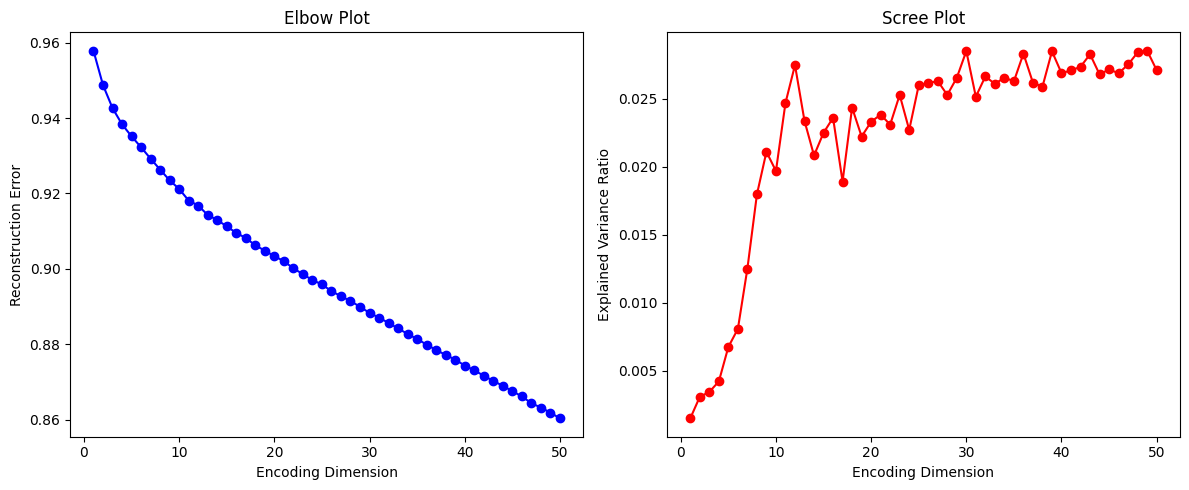

Selected encoding dimension: 50


In [17]:
# 메인 코드
reconstruction_errors, explained_variances = analyze_dimensions(X_scaled, max_dim=50) # 재구성된 에러와 설명된 분산을 함수를 통해 계산
plot_analysis(reconstruction_errors, explained_variances) # 

encoding_dim = select_encoding_dim(explained_variances, min_variance_ratio=0.95)
print(f"Selected encoding dimension: {encoding_dim}")

In [18]:
# 선택된 차원으로 최종 오토인코더 생성 및 학습
final_autoencoder, final_encoder = create_autoencoder(X_scaled.shape[1], encoding_dim)
final_autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=256, shuffle=True, validation_split=0.2)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9620 - val_loss: 0.8786
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8774 - val_loss: 0.8737
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8772 - val_loss: 0.8733
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8719 - val_loss: 0.8739
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8758 - val_loss: 0.8745
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8620 - val_loss: 0.8750
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8680 - val_loss: 0.8759
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8665 - val_loss: 0.8769
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8551 - val_loss: 0.8775
Epoch 10/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8624 - val_loss: 0.8781
Epoch 11/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8590 - val_loss: 0.8791
Epoch 12/100
127/127 ━━━━━━━━━━━━━━━━━━━━

In [19]:
# 축소된 특성 생성
X_reduced = final_encoder.predict(X_scaled)

1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step


In [20]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [21]:
# 훈련셋에 대해 SMOTE 적용
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(f"Train set - Normal: {sum(y_train_resampled == 0)}, AbNormal: {sum(y_train_resampled == 1)}")

After SMOTE:
Train set - Normal: 26709, AbNormal: 26709


In [22]:
# 각 모델의 하이퍼파라미터 탐색 공간 정의
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

lgbm_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'min_split_gain': [0, 0.1, 0.2]
}

catboost_params = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

f1_scorer = make_scorer(f1_score, pos_label='AbNormal')

In [23]:
# RandomizedSearchCV를 이용한 모델 최적화
def optimize_model(model, params, X, y):
    random_search = RandomizedSearchCV(
        model, 
        params, 
        n_iter=20,
        cv=5,
        n_jobs=-1,
        scoring='neg_log_loss',  # log_loss를 사용하여 NaN 방지
        random_state=RANDOM_STATE,
        error_score='raise'  # 에러 발생 시 즉시 중단
    )
    random_search.fit(X, y)
    return random_search.best_estimator_

In [24]:
# 각 모델 정의
xgb = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', enable_categorical=True)
lgbm = LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)  # verbose=-1로 설정하여 경고 메시지 억제
catboost = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

In [25]:
# 각 모델 최적화
xgb_optimized = optimize_model(xgb, xgb_params, X_train_resampled, y_train_resampled)

In [26]:
lgbm_optimized = optimize_model(lgbm, lgbm_params, X_train_resampled, y_train_resampled)

In [27]:
catboost_optimized = optimize_model(catboost, catboost_params, X_train_resampled, y_train_resampled)

In [28]:
# Stacking 앙상블 모델 구축
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_optimized),
        ('lgbm', lgbm_optimized),
        ('catboost', catboost_optimized)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

In [29]:
# 앙상블 모델 학습
stacking_model.fit(X_train_resampled, y_train_resampled)

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1.0, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=True,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=0,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              lear...
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=110, ...)),
                               ('lgbm',
                                LGBMClassifier(colsample_bytree=0.9,
                                               max_depth=5,
                                               min_child_samples=100,
                                               min_split_gain=0.2,
                                               n_estimators=300,
                                               random_state=110, reg_alpha=0,
                                               reg_lambda=0.5, verbose=-1)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x000001E8CA0DC850>)],
                   final_estimator=LogisticRegression())

In [30]:
# 검증 세트에 대한 예측
y_val_pred_ensemble = stacking_model.predict(X_val)

In [31]:
# 모델 성능 평가
abnormal_label_index = list(le.classes_).index('AbNormal')
f1 = f1_score(y_val, y_val_pred_ensemble, pos_label=abnormal_label_index)
print("Model Validation F1 Score:", f1)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_ensemble, target_names=le.classes_))

Model Validation F1 Score: 0.17551963048498845

Classification Report:
              precision    recall  f1-score   support

    AbNormal       0.13      0.27      0.18       705
      Normal       0.95      0.89      0.92     11447

    accuracy                           0.85     12152
   macro avg       0.54      0.58      0.55     12152
weighted avg       0.90      0.85      0.88     12152



In [32]:
# f1-Score: 0.17551963048498845 (Validation Set)

In [33]:
# 테스트 데이터 불러오기 및 전처리
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
set_id = test_data['Set ID']  # Set ID 열 저장
test_data_without_set_id = test_data.drop('Set ID', axis=1)  # Set ID 열 제거
test_data_processed, _ = preprocess_data(test_data_without_set_id, onehot_encoder, is_train=False)

In [34]:
# 훈련 데이터의 특성과 테스트 데이터의 특성을 일치시킵니다.
common_features = list(set(train_features) & set(test_data_processed.columns))
test_X = test_data_processed[common_features]

In [35]:
# 훈련 데이터와 동일한 특성 순서로 재정렬
test_X = test_X.reindex(columns=train_features)

In [36]:
# 테스트 데이터에 대해 스케일링과 Autoencoder를 적용합니다
test_X_scaled = scaler.transform(test_X)
test_X_reduced = final_encoder.predict(test_X_scaled)

543/543 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


In [37]:
# Set ID 열 다시 추가
test_data_processed['Set ID'] = set_id

In [38]:
# 예측
test_pred = stacking_model.predict(test_X_reduced)
test_pred_labels = le.inverse_transform(test_pred)

In [39]:
# 제출 데이터 읽어오기
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred_labels

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [40]:
# 예측 결과 확인
print("\n예측된 레이블 분포:")
print(pd.Series(test_pred_labels).value_counts())


예측된 레이블 분포:
Normal      15293
AbNormal     2068
Name: count, dtype: int64


In [ ]:
# test set f1-score: 0.17264 (174위)